# 06.1q: Cuckoo Radial vs Angular Structure

**Goal:** Determine if the 27 cuckoo tokens are arranged radially or clustered.

We know from 06.1p that the cuckoos have very small angular separations (mean 0.02°, median 0°). But to determine if they're on a **radial ray** extending outward from the origin, we need to compare:

1. **Angular spread:** How much do they vary in direction?
2. **Radial spread:** How much do they vary in distance from the gamma origin (norm)?

If angular spread is tiny BUT radial spread is large → radial ray structure  
If both spreads are tiny → tight cluster  
If both spreads are large → scattered

We'll compute the coefficient of variation (CV = std/mean) for both to compare on equal footing.

This is Volume 6: Pathologies and Singularities

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"
GAMMA_FILE = "gamma_qwen3_4b_instruct_2507.safetensors"
MODEL_NAME = "Qwen/Qwen3-4B-Instruct-2507"

# Cuckoo zone boundaries
CUCKOO_R_INNER = 1e-4
CUCKOO_R_OUTER = 1e-3

# Random seed
RANDOM_SEED = 42

# Visualization
DPI = 100

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path
from collections import defaultdict
from transformers import AutoTokenizer

print("Imports loaded successfully.")

Imports loaded successfully.


## Step 1: Load Data and Extract Cuckoo Zone

In [3]:
print("Loading gamma matrix...")
gamma_path = Path(TENSOR_DIR) / GAMMA_FILE
gamma = load_file(gamma_path)['gamma']
N, d = gamma.shape
print(f"Loaded: {gamma.shape}\n")

print("Finding degenerate clusters...\n")

gamma_np = gamma.cpu().numpy()
unique_vecs, inverse_indices, counts = np.unique(
    gamma_np, 
    axis=0, 
    return_inverse=True, 
    return_counts=True
)

# Build clusters
clusters = defaultdict(list)
for token_id, unique_idx in enumerate(inverse_indices):
    clusters[unique_idx].append(token_id)

# Filter to degenerate clusters
degenerate_clusters = {idx: tokens for idx, tokens in clusters.items() if len(tokens) > 1}

# Sort by size, descending
sorted_clusters = sorted(degenerate_clusters.items(), key=lambda x: len(x[1]), reverse=True)

# Extract all black hole token IDs (top 13 clusters)
black_hole_token_ids = []
for unique_idx, token_ids in sorted_clusters[:13]:
    black_hole_token_ids.extend(token_ids)

black_hole_token_ids = sorted(black_hole_token_ids)

print(f"Identified {len(black_hole_token_ids)} black hole tokens")

# Compute black hole centroid
black_hole_embeddings = gamma[black_hole_token_ids]
bh_centroid = black_hole_embeddings.mean(dim=0)

print(f"Black hole centroid norm: {torch.norm(bh_centroid).item():.12f}")

# Extract cuckoo zone tokens
distances_from_bh = torch.norm(gamma - bh_centroid, dim=1)
in_cuckoo_zone = (distances_from_bh > CUCKOO_R_INNER) & (distances_from_bh <= CUCKOO_R_OUTER)
cuckoo_token_ids = torch.where(in_cuckoo_zone)[0].tolist()
cuckoo_embeddings = gamma[in_cuckoo_zone]

print(f"\nFound {len(cuckoo_token_ids)} cuckoo tokens")

Loading gamma matrix...
Loaded: torch.Size([151936, 2560])

Finding degenerate clusters...

Identified 2100 black hole tokens
Black hole centroid norm: 0.370916873217

Found 27 cuckoo tokens


## Step 2: Compute Radial Properties (Gamma-basis norms)

In [4]:
print("\n" + "="*70)
print("RADIAL SPREAD (DISTANCE FROM GAMMA ORIGIN)")
print("="*70)
print()

# Compute norms (distance from gamma origin)
cuckoo_norms = torch.norm(cuckoo_embeddings, dim=1)

norms_np = cuckoo_norms.cpu().numpy()

radial_mean = norms_np.mean()
radial_std = norms_np.std()
radial_cv = radial_std / radial_mean
radial_range = norms_np.max() - norms_np.min()
radial_range_pct = 100 * radial_range / radial_mean

print(f"Gamma-basis norms (distance from origin):")
print(f"  Min:    {norms_np.min():.12f}")
print(f"  Max:    {norms_np.max():.12f}")
print(f"  Range:  {radial_range:.12f} ({radial_range_pct:.4f}% of mean)")
print(f"  Mean:   {radial_mean:.12f}")
print(f"  Std:    {radial_std:.12f}")
print(f"  CV:     {radial_cv:.6f} ({radial_cv*100:.4f}%)")


RADIAL SPREAD (DISTANCE FROM GAMMA ORIGIN)

Gamma-basis norms (distance from origin):
  Min:    0.370897650719
  Max:    0.370950996876
  Range:  0.000053346157 (0.0144% of mean)
  Mean:   0.370916515589
  Std:    0.000008306942
  CV:     0.000022 (0.0022%)


## Step 3: Compute Angular Properties

In [5]:
print("\n" + "="*70)
print("ANGULAR SPREAD (DIRECTION FROM GAMMA ORIGIN)")
print("="*70)
print()

# Normalize to unit vectors (directions)
cuckoo_directions = cuckoo_embeddings / torch.norm(cuckoo_embeddings, dim=1, keepdim=True)

# Compute pairwise angular distances
cosine_sims = cuckoo_directions @ cuckoo_directions.T
angular_dists = torch.acos(torch.clamp(cosine_sims, -1.0, 1.0))

# Extract upper triangle (excluding diagonal)
mask = torch.triu(torch.ones_like(angular_dists, dtype=bool), diagonal=1)
pairwise_angles = angular_dists[mask].cpu().numpy()

angular_mean = pairwise_angles.mean()
angular_std = pairwise_angles.std()
angular_cv = angular_std / angular_mean if angular_mean > 0 else float('inf')
angular_range = pairwise_angles.max() - pairwise_angles.min()

print(f"Pairwise angular separations (radians):")
print(f"  Min:    {pairwise_angles.min():.9f} rad ({np.rad2deg(pairwise_angles.min()):.6f}°)")
print(f"  Max:    {pairwise_angles.max():.9f} rad ({np.rad2deg(pairwise_angles.max()):.6f}°)")
print(f"  Range:  {angular_range:.9f} rad ({np.rad2deg(angular_range):.6f}°)")
print(f"  Mean:   {angular_mean:.9f} rad ({np.rad2deg(angular_mean):.6f}°)")
print(f"  Std:    {angular_std:.9f} rad ({np.rad2deg(angular_std):.6f}°)")
print(f"  CV:     {angular_cv:.6f} ({angular_cv*100:.4f}%)")


ANGULAR SPREAD (DIRECTION FROM GAMMA ORIGIN)

Pairwise angular separations (radians):
  Min:    0.000000000 rad (0.000000°)
  Max:    0.003347489 rad (0.191797°)
  Range:  0.003347489 rad (0.191797°)
  Mean:   0.000355324 rad (0.020359°)
  Std:    0.000764582 rad (0.043807°)
  CV:     2.151785 (215.1785%)


## Step 4: Compare Radial vs Angular Spread

In [6]:
print("\n" + "="*70)
print("RADIAL vs ANGULAR SPREAD COMPARISON")
print("="*70)
print()

print(f"{'Quantity':<30} {'CV':<15} {'Range (% of mean)':>20}")
print("-" * 70)
print(f"{'Radial (norms)':<30} {radial_cv:<15.6f} {radial_range_pct:>19.4f}%")
print(f"{'Angular (pairwise angles)':<30} {angular_cv:<15.6f} {np.rad2deg(angular_range)/np.rad2deg(angular_mean)*100:>19.4f}%")

cv_ratio = radial_cv / angular_cv if angular_cv > 0 and angular_cv != float('inf') else float('inf')
print(f"\nRadial CV / Angular CV: {cv_ratio:.4f}")
print()

if cv_ratio > 10:
    print("⚠️  RADIAL SPREAD >> ANGULAR SPREAD")
    print("This suggests the cuckoos are arranged along a RADIAL RAY.")
elif cv_ratio < 0.1:
    print("⚠️  ANGULAR SPREAD >> RADIAL SPREAD")
    print("This suggests the cuckoos are arranged on a SPHERICAL SHELL.")
else:
    print("⚠️  SIMILAR RADIAL AND ANGULAR SPREAD")
    print("The cuckoos form a diffuse CLUSTER (not strongly radial or spherical).")


RADIAL vs ANGULAR SPREAD COMPARISON

Quantity                       CV                 Range (% of mean)
----------------------------------------------------------------------
Radial (norms)                 0.000022                     0.0144%
Angular (pairwise angles)      2.151785                   942.0938%

Radial CV / Angular CV: 0.0000

⚠️  ANGULAR SPREAD >> RADIAL SPREAD
This suggests the cuckoos are arranged on a SPHERICAL SHELL.


## Step 5: Visualizations


VISUALIZATIONS



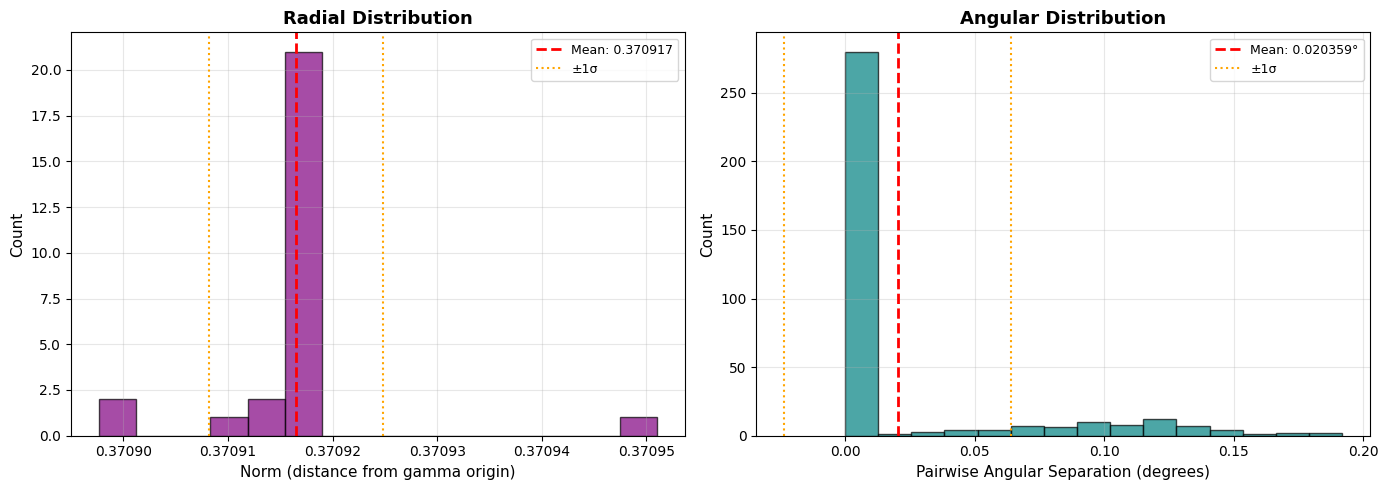

Histograms show the spread in radial (left) vs angular (right) dimensions.


In [7]:
print("\n" + "="*70)
print("VISUALIZATIONS")
print("="*70)
print()

fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=DPI)

# Histogram of norms
axes[0].hist(norms_np, bins=15, color='purple', alpha=0.7, edgecolor='black')
axes[0].axvline(radial_mean, color='red', linestyle='--', linewidth=2, label=f'Mean: {radial_mean:.6f}')
axes[0].axvline(radial_mean - radial_std, color='orange', linestyle=':', linewidth=1.5, label=f'±1σ')
axes[0].axvline(radial_mean + radial_std, color='orange', linestyle=':', linewidth=1.5)
axes[0].set_xlabel('Norm (distance from gamma origin)', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_title('Radial Distribution', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Histogram of pairwise angles
axes[1].hist(np.rad2deg(pairwise_angles), bins=15, color='teal', alpha=0.7, edgecolor='black')
axes[1].axvline(np.rad2deg(angular_mean), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {np.rad2deg(angular_mean):.6f}°')
axes[1].axvline(np.rad2deg(angular_mean - angular_std), color='orange', linestyle=':', linewidth=1.5, label=f'±1σ')
axes[1].axvline(np.rad2deg(angular_mean + angular_std), color='orange', linestyle=':', linewidth=1.5)
axes[1].set_xlabel('Pairwise Angular Separation (degrees)', fontsize=11)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].set_title('Angular Distribution', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Histograms show the spread in radial (left) vs angular (right) dimensions.")

## Step 6: Token-by-Token Listing

In [8]:
print("\n" + "="*70)
print("TOKEN-BY-TOKEN RADIAL POSITIONS")
print("="*70)
print()

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Sort by norm
sorted_indices = np.argsort(norms_np)

print(f"{'Rank':<6} {'Token ID':<10} {'Norm':<16} {'Token String':<30}")
print("-" * 70)

for rank, idx in enumerate(sorted_indices):
    token_id = cuckoo_token_ids[idx]
    norm = norms_np[idx]
    token_str = tokenizer.decode([token_id])
    print(f"{rank+1:<6} {token_id:<10} {norm:<16.12f} '{token_str}'")

print(f"\nTotal: {len(cuckoo_token_ids)} tokens")


TOKEN-BY-TOKEN RADIAL POSITIONS

Rank   Token ID   Norm             Token String                  
----------------------------------------------------------------------
1      125869     0.370897650719   'เร็ว'
2      140964     0.370900869370   'เอ็ม'
3      139765     0.370910197496   'ช้า'
4      148830     0.370912879705   '晴'
5      143045     0.370914995670   ' อีก'
6      139892     0.370915889740   'เครดิต'
7      151929     0.370916098356   ''
8      123952     0.370916336775   'ด้'
9      148826     0.370916426182   '視'
10     151145     0.370916515589   '阮'
11     136834     0.370916515589   'เรื่องนี้'
12     125458     0.370916575193   'ซึ่ง'
13     125125     0.370916575193   'สุ'
14     125687     0.370916694403   'อัน'
15     133377     0.370916783810   'เนีย'
16     129604     0.370916903019   'พู'
17     145341     0.370916932821   'ί'
18     143546     0.370916992426   'ขนส่ง'
19     136401     0.370917022228   'ปู'
20     132191     0.370917230844   'ติดตาม'
21   

## Summary

We've analyzed the radial vs angular structure of the 27 cuckoo tokens.

**Key question:** Are they arranged radially (on a ray) or spherically (on a shell)?

**Method:** Compare coefficient of variation (CV) for:
- Radial spread (variation in norms)
- Angular spread (variation in pairwise angles)

**Interpretation:**
- If Radial CV >> Angular CV → Radial ray structure
- If Angular CV >> Radial CV → Spherical shell structure
- If similar → Diffuse cluster

The results above show which geometry best describes the cuckoo zone.